In [2]:
import pandas as pd 
import re

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import folium
from folium import Polygon
from folium import Choropleth
from folium import Circle, PolyLine

# Configure Notebook
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

### SCHOOLS DATA

In [11]:
#IMPORT SCHOOL'S LOCATION DATA
schools_dataset_full=pd.read_csv('School locations-all types data - 4326.csv')

schools_dataset_full.head()

_id  OBJECTID    GEO_ID                               NAME  SCHOOL_LEVEL  \
0    1         1    330677      A PLUS ACADEMY OF ADVANCEMENT           NaN   
1    2         2    524780      A R S ARMENIAN PRIVATE SCHOOL           NaN   
2    3         3  20258267               A Y J GLOBAL ACADEMY           NaN   
3    4         4    517961       A Y JACKSON SECONDARY SCHOOL           NaN   
4    5         5  13967401  ABACUS MONTESSORI LEARNING CENTRE           NaN   

  SCHOOL_TYPE                     BOARD_NAME       SOURCE_ADDRESS  \
0          PR                            NaN  2425 EGLINTON AVE E   
1          PR                            NaN      50 HALLCROWN PL   
2          PR                            NaN         4 LANSING SQ   
3          EP  Toronto District School Board       50 FRANCINE DR   
4          PR                            NaN    4 CREDIT UNION DR   

  SCHOOL_TYPE_DESC  ADDRESS_POINT_ID  ...     CITY  \
0          Private            330677  ...  Toronto   
1          Private            524780  ...  Toronto   
2          Private          20258267  ...  Toronto   
3   English Public            517961  ...  Toronto   
4          Private          13967401  ...  Toronto   

                       PLACE_NAME GENERAL_USE_CODE CENTRELINE_ID LO_NUM  \
0                             NaN           104008        111254   2425   
1                             NaN           104008        438652     50   
2                             NaN           104008        438287      4   
3  A. Y. Jackson Secondary School           102002        436260     50   
4         Latvian Canadian Centre           106007        444179      4   

  LO_NUM_SUF HI_NUM  HI_NUM_SUF  LINEAR_NAME_ID  \
0        NaN    NaN         NaN             125   
1        NaN    NaN         NaN            5778   
2        NaN    NaN         NaN            6007   
3        NaN    NaN         NaN            5639   
4        NaN    NaN         NaN            5294   

                                            geometry  
0  {'type': 'MultiPoint', 'coordinates': [[-79.26...  
1  {'type': 'MultiPoint', 'coordinates': [[-79.32...  
2  {'type': 'MultiPoint', 'coordinates': [[-79.32...  
3  {'type': 'MultiPoint', 'coordinates': [[-79.36...  
4  {'type': 'MultiPoint', 'coordinates': [[-79.31...  

[5 rows x 25 columns]

In [35]:
#SELECT FEATURES OF INTEREST FOR FURTHER DATA EXPLORATION 
features_of_interest=['NAME','SCHOOL_TYPE_DESC','ADDRESS_FULL','POSTAL_CODE','MUNICIPALITY','CITY','geometry']

# Convert names to lowercase for consistency
schools_dataset_full['NAME'] = schools_dataset_full['NAME'].str.lower()

# #ASSIGN FRACTION OF THE DATA SET TO A NEW DATAFRAME
schools_dataset=schools_dataset_full[features_of_interest]

In [37]:
#ASSIGN THE SAME CATEGORY FOR EACH SUBSET OF SCHOOL TYPES THAT ARE SIMILAR. THIS ALLOWS TO GENERALIZE THE DATA AND HAVE FEWER CATEGORIES BY GROUPING ALIKE ONES TOGETHER
education_category_list={'child care':['child care', 'day care','daycare'],
                         'elementary school':['elementary school','école élémentaire', 'public school'],
                         'college':['college'],
                         'university':['university'],
                         'highschool':['secondary','highschool','high school'],
                         'learning centre':['learning centre '],
                         'academy':['academy']}

schools_dataset.loc[:, 'school_level'] = schools_dataset['NAME'].apply(lambda df: [category for category, keywords in education_category_list.items() if any(keyword in df for keyword in keywords)][0] 
                                                                       if [category for category, keywords in education_category_list.items() if any(keyword in df for keyword in keywords)] else None)

schools_dataset.head()

NAME SCHOOL_TYPE_DESC         ADDRESS_FULL  \
0      a plus academy of advancement          Private  2425 Eglinton Ave E   
1      a r s armenian private school          Private      50 Hallcrown Pl   
2               a y j global academy          Private         4 Lansing Sq   
3       a y jackson secondary school   English Public       50 Francine Dr   
4  abacus montessori learning centre          Private    4 Credit Union Dr   

  POSTAL_CODE MUNICIPALITY     CITY  \
0     M1K 5G8  Scarborough  Toronto   
1     M2J 1P7   North York  Toronto   
2     M2J 5A2   North York  Toronto   
3     M2H 2G6   North York  Toronto   
4     M4A 2N8   North York  Toronto   

                                            geometry school_level  
0  {'type': 'MultiPoint', 'coordinates': [[-79.26...      academy  
1  {'type': 'MultiPoint', 'coordinates': [[-79.32...         None  
2  {'type': 'MultiPoint', 'coordinates': [[-79.32...      academy  
3  {'type': 'MultiPoint', 'coordinates': [[-79.36...   highschool  
4  {'type': 'MultiPoint', 'coordinates': [[-79.31...         None

In [38]:
#CREATE A FUNCTION TO EXTRAC THE LATITUDE AND LONGITUDE FROM A STRING WHICH FOLLOWS A SPECIFIC FORMAT
def extract_location(string):
    ''' RETURNS THE FLOAT VALUE OF THE LATITUDE AND LONGITUDE FROM A STRING CONTAINING THOSE WITHIN A SPECIFIC STRING STRUCTURE '''
    
    pattern = r'\[(?P<longitude>[-+]?\d*\.\d+|\d+), (?P<latitude>[-+]?\d*\.\d+|\d+)\]'

    matches = re.search(pattern, string)

    if matches:
        long = float(matches.group('longitude'))
        lat = float(matches.group('latitude'))
    else:
        lat = None
        long = None

    return lat,long


In [39]:
# EXTRACT CO-ORDINATES TO ALLOW FOR SPACIAL DATA EXPLORATION AND MAPPING
schools_dataset.loc[:,'co-ordinates'] = schools_dataset['geometry'].apply(extract_location)
schools_dataset.drop(columns='geometry',inplace=True)

#FOR SCHOOL TYPES THAT ARE NOT AS COMMON WE APPLY A CATEGORY OF EDUCATIONAL CENTRES
schools_dataset['school_level'].fillna('education_centres',inplace=True)

#CONVERT FLOATS INTO A POINT OBJECT WHICH CAN BE RECOGNIZED BY GEOPANDAS
schools_dataset['point_geometry']=schools_dataset['co-ordinates'].apply(lambda row: Point(row[1],row[0]))

schools_dataset_gpd=gpd.GeoDataFrame(schools_dataset, geometry='point_geometry')
schools_dataset_gpd

NAME SCHOOL_TYPE_DESC         ADDRESS_FULL  \
0         a plus academy of advancement          Private  2425 Eglinton Ave E   
1         a r s armenian private school          Private      50 Hallcrown Pl   
2                  a y j global academy          Private         4 Lansing Sq   
3          a y jackson secondary school   English Public       50 Francine Dr   
4     abacus montessori learning centre          Private    4 Credit Union Dr   
...                                 ...              ...                  ...   
1189               yorkland high school          Private     3840 Finch Ave E   
1190             yorkview public school   English Public      130 Yorkview Dr   
1191            yorkwoods public school   English Public      25 Yorkwoods Gt   
1192         z3 education centre school          Private      1200 Markham Rd   
1193    zion heights junior high school   English Public       5900 Leslie St   

     POSTAL_CODE MUNICIPALITY     CITY       school_level  \
0        M1K 5G8  Scarborough  Toronto            academy   
1        M2J 1P7   North York  Toronto  education_centres   
2        M2J 5A2   North York  Toronto            academy   
3        M2H 2G6   North York  Toronto         highschool   
4        M4A 2N8   North York  Toronto  education_centres   
...          ...          ...      ...                ...   
1189     M1T 3T4  Scarborough  Toronto         highschool   
1190     M2R 1K1   North York  Toronto  elementary school   
1191     M3N 1K1   North York  Toronto  elementary school   
1192     M1H 3C3  Scarborough  Toronto  education_centres   
1193     M2H 1J9   North York  Toronto         highschool   

                               co-ordinates              point_geometry  
0      (43.7320819460129, -79.267103936897)  POINT (-79.26710 43.73208)  
1       (43.770053062482, -79.323156147744)  POINT (-79.32316 43.77005)  
2      (43.774082570705, -79.3252164120635)  POINT (-79.32522 43.77408)  
3     (43.8052613014219, -79.3665552934095)  POINT (-79.36656 43.80526)  
4      (43.725432232812, -79.3190099774403)  POINT (-79.31901 43.72543)  
...                                     ...                         ...  
1189  (43.8006150838616, -79.3013419576388)  POINT (-79.30134 43.80062)  
1190  (43.7725736106375, -79.4355664221908)  POINT (-79.43557 43.77257)  
1191  (43.7506598381465, -79.5138847463308)  POINT (-79.51388 43.75066)  
1192   (43.7766098499215, -79.232117555141)  POINT (-79.23212 43.77661)  
1193  (43.7979149025647, -79.3710972374637)  POINT (-79.37110 43.79791)  

[1194 rows x 9 columns]

### GREEN SPACES DATA


In [40]:
# THESE DATASETS COME FROM THE SAME GOVERNMENT SOURCE AND THUS FOLLOW A SIMILAR FORMATTING. FOR EACH SET WE WILL FOLLOW A SIMIALR PROCEEDURE AS THE ONE DESCRIBED FOR SCHOOL DATA
greenspace=pd.read_csv('Green Spaces - 4326.csv')
features_of_interest=['AREA_CLASS','AREA_NAME','geometry']

green_space_database=greenspace[features_of_interest]
green_space_database['geometry']=green_space_database['geometry'].apply(extract_location)
green_space_database['point_geometry']=green_space_database['geometry'].apply(lambda row: Point(row[1],row[0]))

#GROUP SPACES BY SIMILAR TYPES TO DECREASE CATEGORY COLUMNS
green_space_database['Category']= green_space_database['AREA_CLASS'].map({'OTHER_CEMETERY':'cemetery',
                                                        'Cemetery':'cemetery',
                                                        'Park':'green_space',
                                                        'Open Green Space': 'green_space'})

green_space_database=green_space_database.dropna(subset='Category')

green_space_database_gpd=gpd.GeoDataFrame(green_space_database,geometry='point_geometry')
green_space_database_gpd

AREA_CLASS                            AREA_NAME  \
0     OTHER_CEMETERY     ARMADALE FREE METHODIST CEMETERY   
1     OTHER_CEMETERY                    HILLSIDE CEMETERY   
2     OTHER_CEMETERY              HIGHLAND MEMORY GARDENS   
3     OTHER_CEMETERY        CHRISTIE'S METHODIST CEMETERY   
4     OTHER_CEMETERY  ST. PAUL'S ANGLICAN CHURCH CEMETERY   
...              ...                                  ...   
3276            Park            DR. LILLIAN MCGREGOR PARK   
3277            Park                      BEARE HILL PARK   
3278            Park                DAVID A. BALFOUR PARK   
3279            Park               WEST TORONTO RAIL PATH   
3280            Park                   JUNE CALLWOOD PARK   

                                   geometry              point_geometry  \
0     (43.8295273173239, -79.2575176187252)  POINT (-79.25752 43.82953)   
1     (43.8248759979817, -79.1896234436736)  POINT (-79.18962 43.82488)   
2     (43.8081040400068, -79.3475814552969)  POINT (-79.34758 43.80810)   
3     (43.7990227367807, -79.3183490480703)  POINT (-79.31835 43.79902)   
4     (43.7964022079953, -79.3164872662631)  POINT (-79.31649 43.79640)   
...                                     ...                         ...   
3276  (43.6644688565639, -79.3856737006167)  POINT (-79.38567 43.66447)   
3277  (43.8303714676479, -79.1590613591364)  POINT (-79.15906 43.83037)   
3278  (43.6879236668976, -79.3863957091914)  POINT (-79.38640 43.68792)   
3279    (43.662838617392, -79.455344754934)  POINT (-79.45534 43.66284)   
3280  (43.6374238022085, -79.4039563080891)  POINT (-79.40396 43.63742)   

         Category  
0        cemetery  
1        cemetery  
2        cemetery  
3        cemetery  
4        cemetery  
...           ...  
3276  green_space  
3277  green_space  
3278  green_space  
3279  green_space  
3280  green_space  

[1673 rows x 5 columns]

### SUBWAY STATIONS DATA

In [41]:
subway_stations = gpd.read_file('subway_stations.shp', crs='epsg26917')
features_of_interest=['STATION','LINE','AVG_PASSEN','geometry']

subway_stations_database=subway_stations[features_of_interest]

subway_stations_database=subway_stations_database.to_crs(epsg=4326)
subway_stations_database


STATION                      LINE  AVG_PASSEN  \
0      Kipling            Bloor-Danforth       53640   
1    Islington            Bloor-Danforth       43090   
2   Royal York            Bloor-Danforth       19440   
3     Old Mill            Bloor-Danforth        5780   
4         Jane            Bloor-Danforth       16730   
..         ...                       ...         ...   
60   Downsview  Yonge-University-Spadina       31600   
61     Bayview                  Sheppard        8200   
62   Bessarion                  Sheppard        2590   
63      Leslie                  Sheppard        5610   
64   Don Mills                  Sheppard       31500   

                      geometry  
0   POINT (-79.53583 43.63734)  
1   POINT (-79.52461 43.64537)  
2   POINT (-79.51133 43.64825)  
3   POINT (-79.49510 43.65010)  
4   POINT (-79.48445 43.64978)  
..                         ...  
60  POINT (-79.46245 43.74980)  
61  POINT (-79.38780 43.76676)  
62  POINT (-79.37665 43.76918)  
63  POINT (-79.36683 43.77093)  
64  POINT (-79.34626 43.77532)  

[65 rows x 4 columns]

### HOUSE DATA 

In [42]:
house_prices = pd.read_csv('houses_data_final.csv')

# Create a geodataframe from the houses dataframe with longitude and latidue as geometry
house_prices_gpd = gpd.GeoDataFrame(house_prices, geometry = 
                                          gpd.points_from_xy(house_prices['propertyLng'], house_prices['propertyLat']))
house_prices_gpd.crs = {'init': 'epsg:4326'}

#CREATE A RADIUS AROUD EACH HOUSE LOCATION TO SEE THE AREA IT COVERS AND THE INFASTRUCTURES WITHIN SUCH AREA
house_prices_gpd['circle_polygon']=house_prices_gpd['geometry'].apply(lambda point: point.buffer(2000/(40008000/360))) #buffer takes the radius of the circle. because our projected crs is epsg 4326 it is in degrees and meters must be converted to degrees

In [43]:
def get_price(row):
    """The following funtion takes in a row and returns the 'Sold Price' if it exists, otherwise it returns
    the listing price."""
    if row['Sold Price'] == None:
        return row['List Price']
    else:
        return row['Sold Price']

In [44]:
# Create Price column, where it is the sold price, or list price if there is no sold price
house_prices_gpd['Price'] = house_prices_gpd.apply(get_price, axis = 1)

# drop the original Sold Price and List Price Columns
house_prices_gpd.drop(columns = ['Sold Price','List Price'], inplace = True)
house_prices_gpd = house_prices_gpd.dropna(subset = 'Price') # drop houses with no prices
house_prices_gpd.info()

#DUE TO THE PRICE DATA HAVING A LARGE RANGE BY TAKING THE LOG WE AIM TO DECREASE SUCH SPREAD AND HELP VISUALIZATIONS
house_prices_gpd['log_adj_price']=np.log(house_prices_gpd['Price'])

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 136272 entries, 0 to 178045
Data columns (total 54 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Unnamed: 0.1            136272 non-null  int64   
 1   Unnamed: 0              136272 non-null  int64   
 2   address                 136272 non-null  object  
 3   isResidentialProperty   136272 non-null  object  
 4   propertyLat             136272 non-null  float64 
 5   propertyLng             136272 non-null  float64 
 6   searchNeighborhood      136272 non-null  object  
 7   List Date               136272 non-null  object  
 8   Original Price          89004 non-null   float64 
 9   Type                    136271 non-null  object  
 10  Style                   136161 non-null  object  
 11  Size (sq ft)            34881 non-null   object  
 12  Age                     34621 non-null   object  
 13  Community               136272 non-null  object  
 

### MAP THE BUFFER RADIUS FOR ONE HOUSE TO ENSURE NO ERRORS

In [45]:
neighbourhoods = gpd.read_file('toronto_neighbourhoods.shp')
pattern= r'(\D+)[^()\d]'
neighbourhoods['FIELD_8']=neighbourhoods.apply(lambda row:[matches for matches in re.findall(pattern,row['FIELD_8'])][0],axis=1)
neighbourhoods=neighbourhoods[['geometry','FIELD_8']].rename(columns={'FIELD_8':'neighbourhood'})
neighbourhoods.to_crs(epsg='4326',inplace=True)

house_prices_gpd_clean = house_prices_gpd.sjoin(neighbourhoods, how = "left")

In [46]:
map_1 = folium.Map(location=[43.6426, -79.3871], tiles='cartodbpositron', zoom_start=10)

# Add Circle
Circle(location=[house_prices_gpd_clean['geometry'][0].y, house_prices_gpd_clean['geometry'][0].x],
       radius=20, color='forestgreen').add_to(map_1)

# Extract coordinates from the exterior of the Polygon
polygon_coordinates = house_prices_gpd_clean['circle_polygon'][0].exterior.coords.xy
polygon_coordinates = list(zip(polygon_coordinates[1], polygon_coordinates[0]))

# Add Polygon using PolyLine
PolyLine(locations=polygon_coordinates + [polygon_coordinates[0]], color='red', fill=False).add_to(map_1)

# Display the map
map_1


### ADJUST HOUSE_PRICES WITH SCHOOLS

In [47]:
for identifier in schools_dataset_gpd['school_level'].unique():
    x = schools_dataset_gpd[schools_dataset_gpd['school_level'] == identifier]

    #CHECK IF THERE ARE ANY SCHOOLS FOR EACH TYPE FOR EACH HOUSE LOCATION WITHIN ITS BUFFER RADIUS. AS WELL AS HOW MANY ARE WITHING ITS RADIUS
    house_prices_gpd_clean[f'within_{identifier}'] = house_prices_gpd_clean['circle_polygon'].apply(lambda geom: any(x['point_geometry'].within(geom))).astype(int)
    house_prices_gpd_clean[f'#_of_{identifier}_within'] = house_prices_gpd_clean['circle_polygon'].apply(lambda geom: sum(geom.contains(x['point_geometry'])))

In [48]:
#ENSURE CODE IS WORKING CORRECTLY AND NO FALSE COUNTING OCCOURED. EX. IF SCHOOL IS NOT WITHING AREA THE # OF SHCOOLS WITHING THAT AREA SHOULD ALSO BE 0
house_prices_gpd_clean[[
    'circle_polygon','within_academy','#_of_academy_within','within_highschool','#_of_highschool_within']].head()

circle_polygon  within_academy  \
0  POLYGON ((-79.54270 43.73370, -79.54279 43.731...               1   
1  POLYGON ((-79.30560 43.80010, -79.30569 43.798...               1   
3  POLYGON ((-79.44310 43.76160, -79.44319 43.759...               1   
4  POLYGON ((-79.44430 43.72140, -79.44439 43.719...               1   
6  POLYGON ((-79.39240 43.72660, -79.39249 43.724...               1   

   #_of_academy_within  within_highschool  #_of_highschool_within  
0                    2                  1                       2  
1                    6                  1                       4  
3                    3                  0                       0  
4                    1                  1                       2  
6                    2                  1                       1

### ADJUST HOUSE_PRICES WITH SUBWAY STATIONS

In [49]:
house_prices_gpd_clean['within_subway_station'] = house_prices_gpd_clean['circle_polygon'].apply(lambda geom: any(subway_stations_database.geometry.within(geom))).astype(int)
house_prices_gpd_clean['#_of_subway_station_within'] = house_prices_gpd_clean['circle_polygon'].apply(lambda geom: sum(geom.contains(subway_stations_database.geometry)))

In [50]:
house_prices_gpd_clean[['within_subway_station','#_of_subway_station_within']].head()

within_subway_station  #_of_subway_station_within
0                      0                           0
1                      0                           0
3                      1                           1
4                      1                           2
6                      1                           1

### ADJUST HOUSE_PRICES WITH GREEN SPACES 

In [54]:
for identifier in green_space_database_gpd['Category'].unique():
    G=green_space_database_gpd[green_space_database_gpd['Category']==identifier]

    house_prices_gpd_clean[f'within_{identifier}'] = house_prices_gpd_clean['circle_polygon'].apply(lambda geom: any(G['point_geometry'].within(geom))).astype(int)
    house_prices_gpd_clean[f'#_of_{identifier}_within'] = house_prices_gpd_clean['circle_polygon'].apply(lambda geom: sum(geom.contains(G['point_geometry'])))

KeyboardInterrupt: 

In [57]:
house_prices_gpd_clean.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 136272 entries, 0 to 178045
Data columns (total 77 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   Unnamed: 0.1                   136272 non-null  int64   
 1   Unnamed: 0                     136272 non-null  int64   
 2   address                        136272 non-null  object  
 3   isResidentialProperty          136272 non-null  object  
 4   propertyLat                    136272 non-null  float64 
 5   propertyLng                    136272 non-null  float64 
 6   searchNeighborhood             136272 non-null  object  
 7   List Date                      136272 non-null  object  
 8   Original Price                 89004 non-null   float64 
 9   Type                           136271 non-null  object  
 10  Style                          136161 non-null  object  
 11  Size (sq ft)                   34881 non-null   object  
 12  Age     

In [59]:
#SAVE FINAL CSV WITH ALL NEW FEAUTURE COLUMNS 
new_features = house_prices_gpd_clean[['within_academy', '#_of_academy_within', 'within_education_centres',
                                     '#_of_education_centres_within', 'within_highschool', 
                                     '#_of_highschool_within', 'within_elementary school',
                                     '#_of_elementary school_within', 'within_college', '#_of_college_within',
                                     'within_learning centre', '#_of_learning centre_within', 'within_university',
                                     '#_of_university_within', 'within_subway_station', 
                                     '#_of_subway_station_within', 'within_cemetery', '#_of_cemetery_within',
                                     'within_green_space', '#_of_green_space_within']]
new_features.to_csv('nearby_features.csv',index=False)    

### MAP ALL SCHOOL LATIONS TO ENSURE THERE ARE NO ERRORS AND ALL SHCOLLS FALL WITHIN THE GTA

In [60]:
list_of_databases=[subway_stations_database,green_space_database,schools_dataset]
schools_dataset_gpd.crs = {'init': 'epsg:4326'}

map_1 = folium.Map(location = [43.6426, -79.3871], tiles = 'cartodbpositron', zoom_start = 10)

for idx, row in schools_dataset_gpd.to_crs(epsg = 4326).iterrows():
    Circle(location = [row.point_geometry.y, row.point_geometry.x], radius = 20, color = 'forestgreen').add_to(map_1)

map_1

### MAP ALL SCHOOLS, GREEN SPACES, AND HOMES TO ENSURE NO ERRORS WITH COUNTS WITHIN EACH HOUSE RADIUS

In [ ]:
map_3 = folium.Map(location=[43.6426, -79.3871], tiles='cartodbpositron', zoom_start=10)

for idx, row in house_prices_gpd_clean.iterrows():
    Circle(location = [row.geometry.y, row.geometry.x], radius = 20, color = 'black').add_to(map_3)
    
for idx,row in green_space_database_gpd.iterrows():
    Circle(location = [row.point_geometry.y, row.point_geometry.x], radius = 20, color = 'green').add_to(map_3)

for idx, row in schools_dataset_gpd.to_crs(epsg = 4326).iterrows():
    Circle(location = [row.point_geometry.y, row.point_geometry.x], radius = 20, color = 'red').add_to(map_3)

for idx, row in subway_stations_database.to_crs(epsg = 4326).iterrows():
    Circle(location = [row.geometry.y, row.geometry.x], radius = 20, color = 'yellow').add_to(map_3)
map_3


### PLOT ALL CHROLOMAPS WITH DIFFERENT FEATURES

In [61]:
# Create a base map
plot_geography = neighbourhoods.to_crs(epsg=4326)[['neighbourhood', 'geometry']]
plot_data = house_prices_gpd_clean[['neighbourhood', '#_of_subway_station_within']]

map_6 = folium.Map(location=[43.6426, -79.3871], 
                   tiles='cartodbpositron',
                   zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=plot_geography.__geo_interface__, 
           data=plot_data, 
           columns=['neighbourhood', '#_of_subway_station_within'],
           key_on='feature.properties.neighbourhood', 
           fill_color='YlOrRd', 
           legend_name='# of sumbway stations within 2k radius from size (sqft)'
          ).add_to(map_6)

# Display the map
map_6

In [62]:
# Create a base map
plot_geography = neighbourhoods.to_crs(epsg=4326)[['neighbourhood', 'geometry']]
plot_data = house_prices_gpd_clean[['neighbourhood', 'within_university']]

map_6 = folium.Map(location=[43.6426, -79.3871], 
                   tiles='cartodbpositron',
                   zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=plot_geography.__geo_interface__, 
           data=plot_data, 
           columns=['neighbourhood', 'within_university'],
           key_on='feature.properties.neighbourhood', 
           fill_color='YlOrRd', 
           legend_name='University Within 2k Radius From Homes'
          ).add_to(map_6)

# Display the map
map_6

In [63]:
# Create a base map
plot_geography = neighbourhoods.to_crs(epsg=4326)[['neighbourhood', 'geometry']]
plot_data = house_prices_gpd_clean[['neighbourhood', '#_of_elementary school_within']]

map_6 = folium.Map(location=[43.6426, -79.3871], 
                   tiles='cartodbpositron',
                   zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=plot_geography.__geo_interface__, 
           data=plot_data, 
           columns=['neighbourhood', '#_of_elementary school_within'],
           key_on='feature.properties.neighbourhood', 
           fill_color='YlOrRd', 
           legend_name='within university  of 2k radius from homes'
          ).add_to(map_6)

# Display the map
map_6

In [64]:
# Create a base map
plot_geography = neighbourhoods.to_crs(epsg=4326)[['neighbourhood', 'geometry']]
plot_data = house_prices_gpd_clean[['neighbourhood', '#_of_education_centres_within']]

map_6 = folium.Map(location=[43.6426, -79.3871], 
                   tiles='cartodbpositron',
                   zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=plot_geography.__geo_interface__, 
           data=plot_data, 
           columns=['neighbourhood', '#_of_education_centres_within'],
           key_on='feature.properties.neighbourhood', 
           fill_color='YlOrRd', 
           legend_name='within university  of 2k radius from homes'
          ).add_to(map_6)

# Display the map
map_6

WE HAVE ANALYZED THE FOLLOWING WITH ALL THE INFASTRUCTURES DATA AND ALTOUGH IT WAS NOT VERY CLEAR WHY THE Rosedale AREA IS MORE EXPENSIVE THAN OTHERS DESPITE HAVING A SIMILAR CRIME RATE WE STILL CAN COMPARE WITH THE DISTRIBUTION OF TYPES OF BUILDINGS... 

### PLOT THE HOUSE PRICE DISTRIBUTIONS RELATIVE TO THE INFASTRUCTURES THEY ARE WITHIN

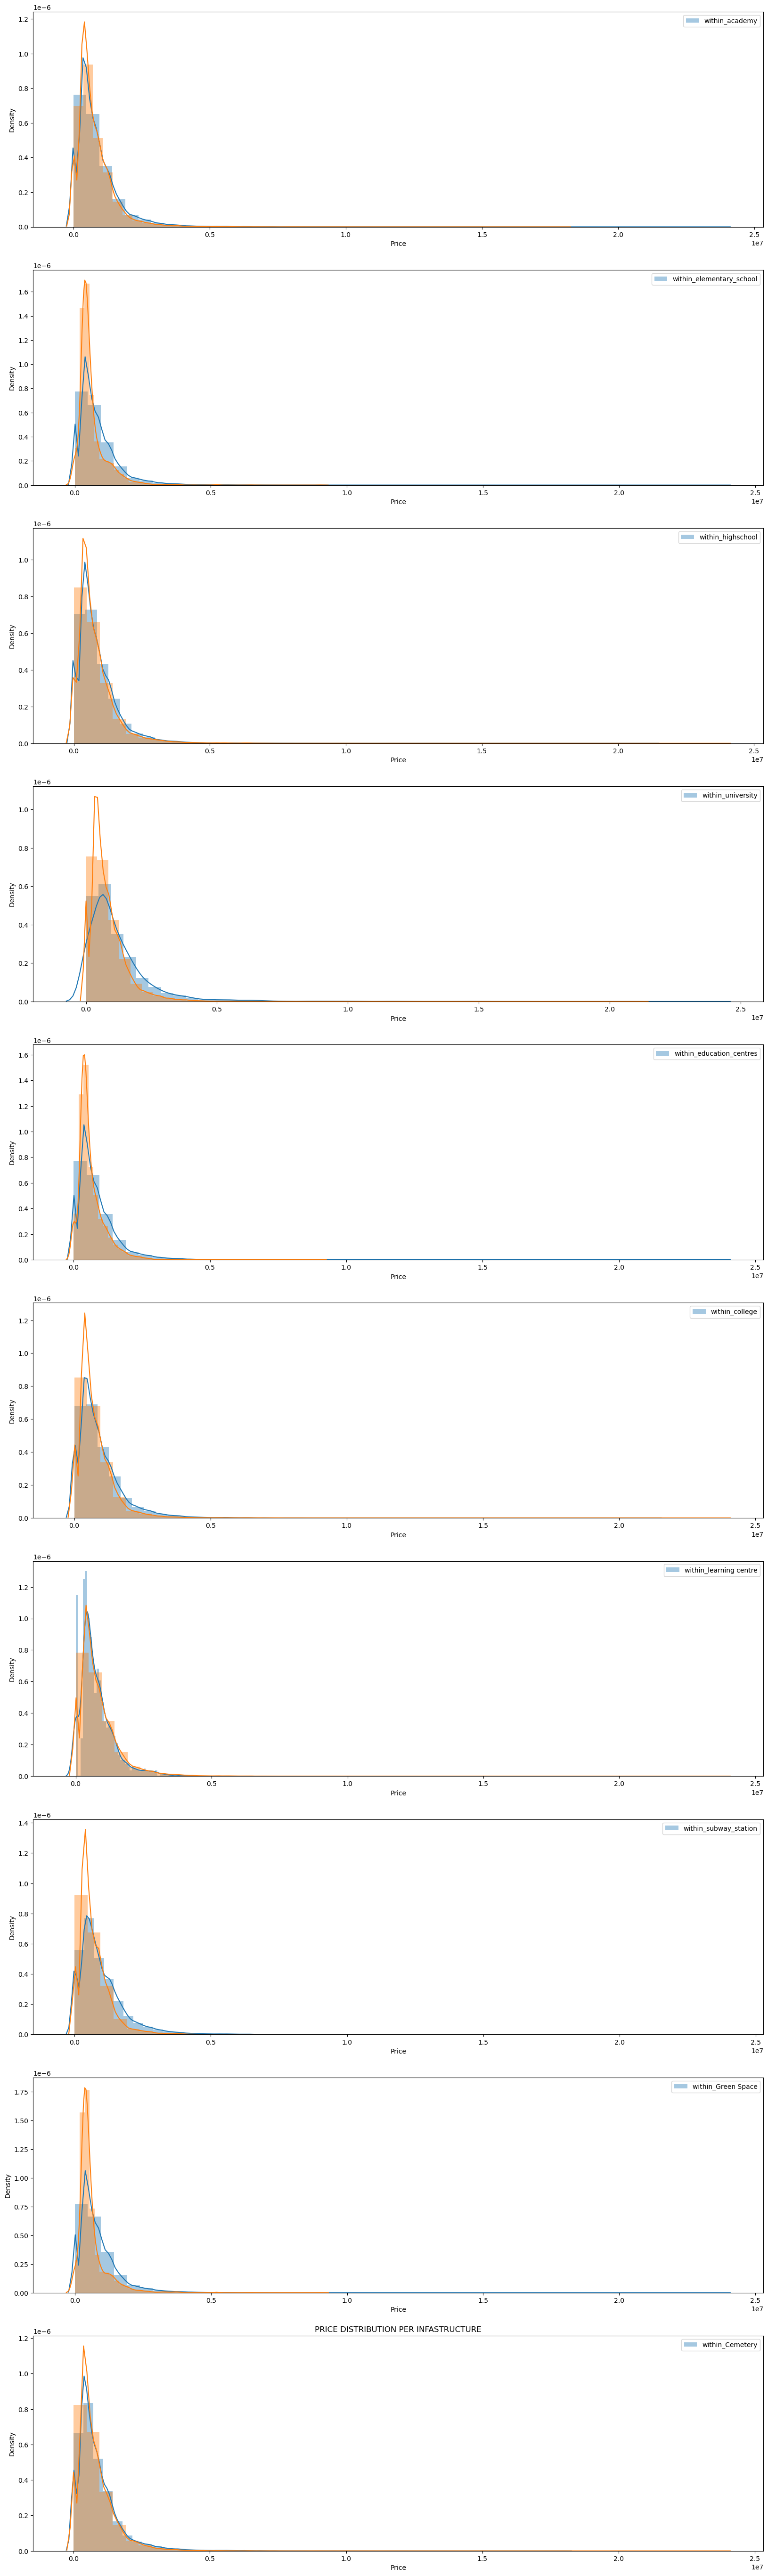

In [65]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)=plt.subplots(10,1,figsize=(20,70))

plt.title('PRICE DISTRIBUTION PER INFASTRUCTURE')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_academy']==1,'Price'],ax=ax1,label='within_academy')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_academy']==0,'Price'],ax=ax1)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_elementary school']==1,'Price'],ax=ax2,label='within_elementary_school')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_elementary school']==0,'Price'],ax=ax2)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_highschool']==1,'Price'],ax=ax3,label='within_highschool')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_highschool']==0,'Price'],ax=ax3)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_university']==1,'Price'],ax=ax4,label='within_university')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_university']==0,'Price'],ax=ax4)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_education_centres']==1,'Price'],ax=ax5,label='within_education_centres')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_education_centres']==0,'Price'],ax=ax5)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_college']==1,'Price'],ax=ax6,label='within_college')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_college']==0,'Price'],ax=ax6)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_learning centre']==1,'Price'],ax=ax7,label='within_learning centre')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_learning centre']==0,'Price'],ax=ax7)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_subway_station']==1,'Price'],ax=ax8,label='within_subway_station')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_subway_station']==0,'Price'],ax=ax8)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_green_space']==1,'Price'],ax=ax9,label='within_Green Space')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_green_space']==0,'Price'],ax=ax9)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_cemetery']==1,'Price'],ax=ax10,label='within_Cemetery')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_cemetery']==0,'Price'],ax=ax10)
	


ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()
ax9.legend()
ax10.legend()


### PLOT THE DISTRIBUTION WITH THE LOG OF THE HOUSE PRICES TO SEE IF TI LEADS TO CLEANER VISUALS

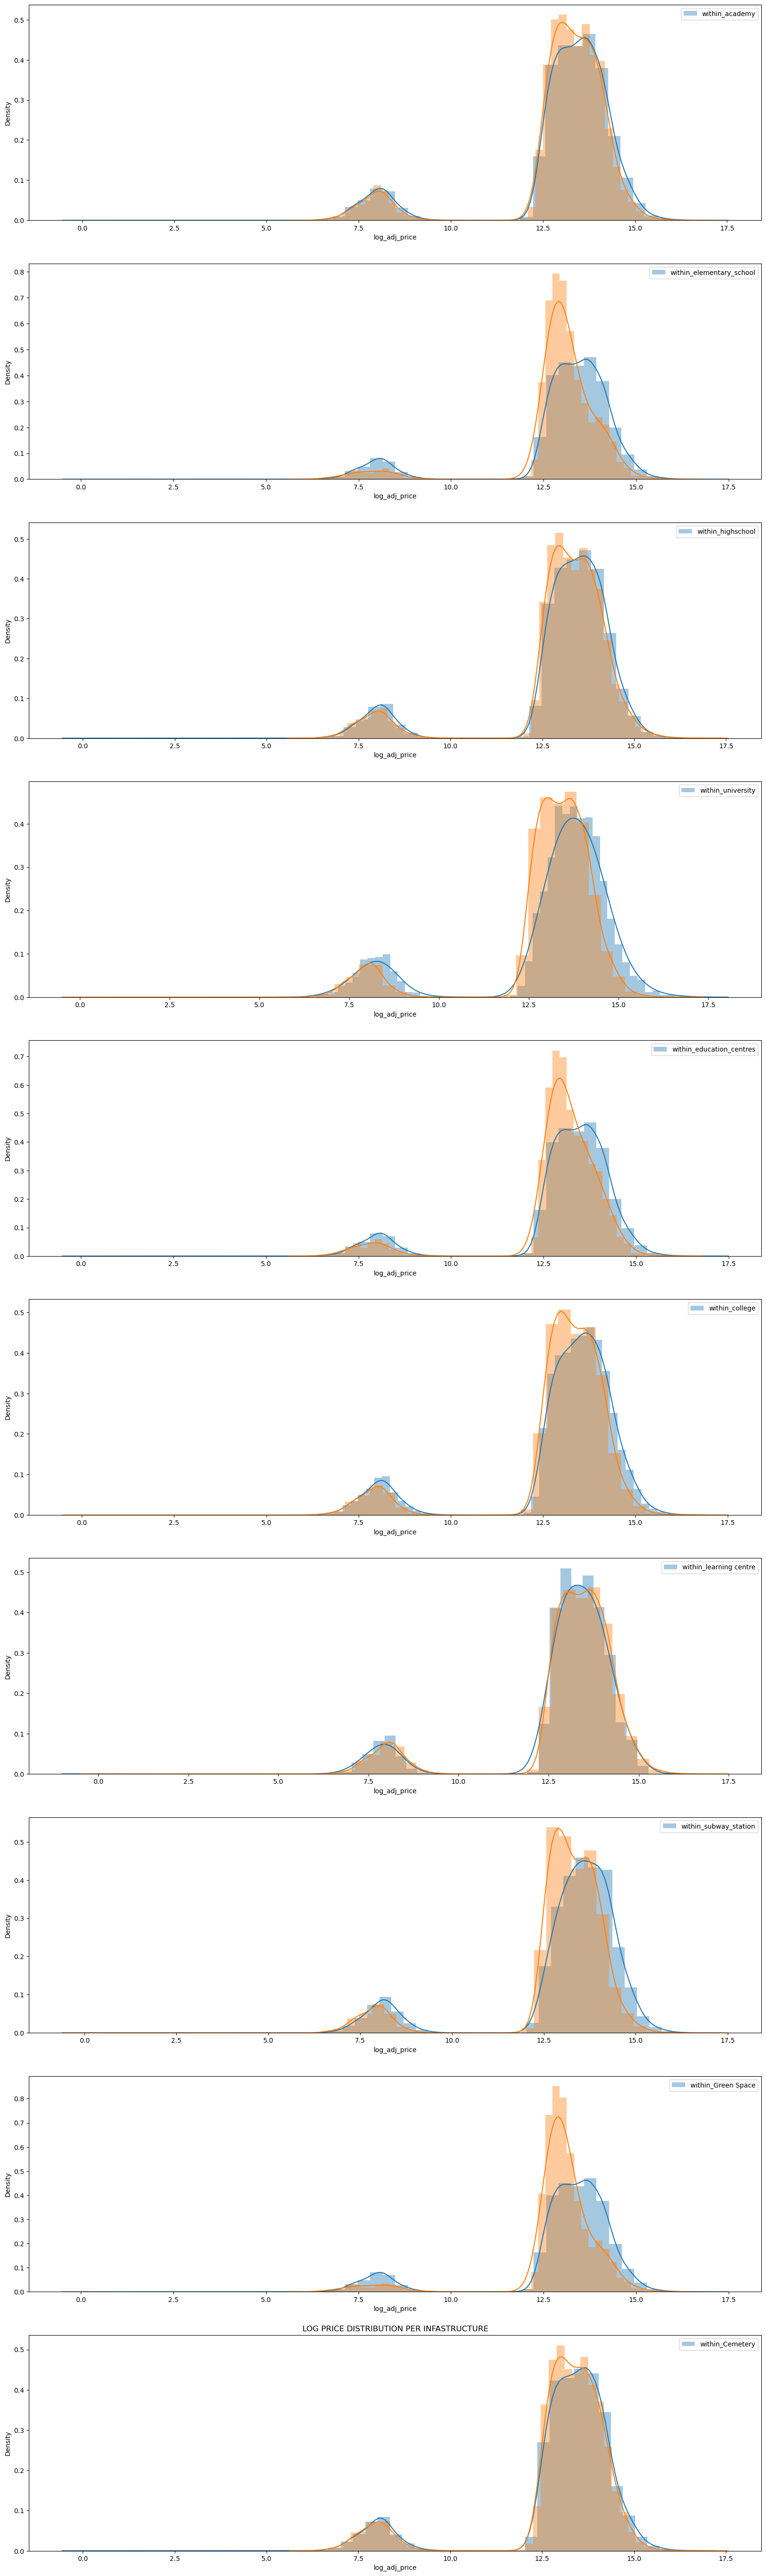

In [74]:
house_prices_gpd_clean = house_prices_gpd_clean[(house_prices_gpd_clean['log_adj_price'] < np.inf) &
                                               (house_prices_gpd_clean['log_adj_price'] > -np.inf)]
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)=plt.subplots(10,1,figsize=(20,70))

plt.title('LOG PRICE DISTRIBUTION PER INFASTRUCTURE')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_academy']==1,'log_adj_price'],ax=ax1,label='within_academy')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_academy']==0,'log_adj_price'],ax=ax1)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_elementary school']==1,'log_adj_price'],ax=ax2,label='within_elementary_school')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_elementary school']==0,'log_adj_price'],ax=ax2)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_highschool']==1,'log_adj_price'],ax=ax3,label='within_highschool')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_highschool']==0,'log_adj_price'],ax=ax3)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_university']==1,'log_adj_price'],ax=ax4,label='within_university')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_university']==0,'log_adj_price'],ax=ax4)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_education_centres']==1,'log_adj_price'],ax=ax5,label='within_education_centres')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_education_centres']==0,'log_adj_price'],ax=ax5)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_college']==1,'log_adj_price'],ax=ax6,label='within_college')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_college']==0,'log_adj_price'],ax=ax6)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_learning centre']==1,'log_adj_price'],ax=ax7,label='within_learning centre')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_learning centre']==0,'log_adj_price'],ax=ax7)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_subway_station']==1,'log_adj_price'],ax=ax8,label='within_subway_station')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_subway_station']==0,'log_adj_price'],ax=ax8)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_green_space']==1,'log_adj_price'],ax=ax9,label='within_Green Space')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_green_space']==0,'log_adj_price'],ax=ax9)

sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_cemetery']==1,'log_adj_price'],ax=ax10,label='within_Cemetery')
sns.distplot(house_prices_gpd_clean.loc[house_prices_gpd_clean['within_cemetery']==0,'log_adj_price'],ax=ax10)
	


ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()
ax9.legend()
ax10.legend()

### PLOT SCATTERPLOTS TO VISUALIZE TRENDS RELATIVE TO NUMBER OF INFASTRUCTURES WITHIN HOUSE

<Axes: xlabel='#_of_green_space_within', ylabel='Price'>

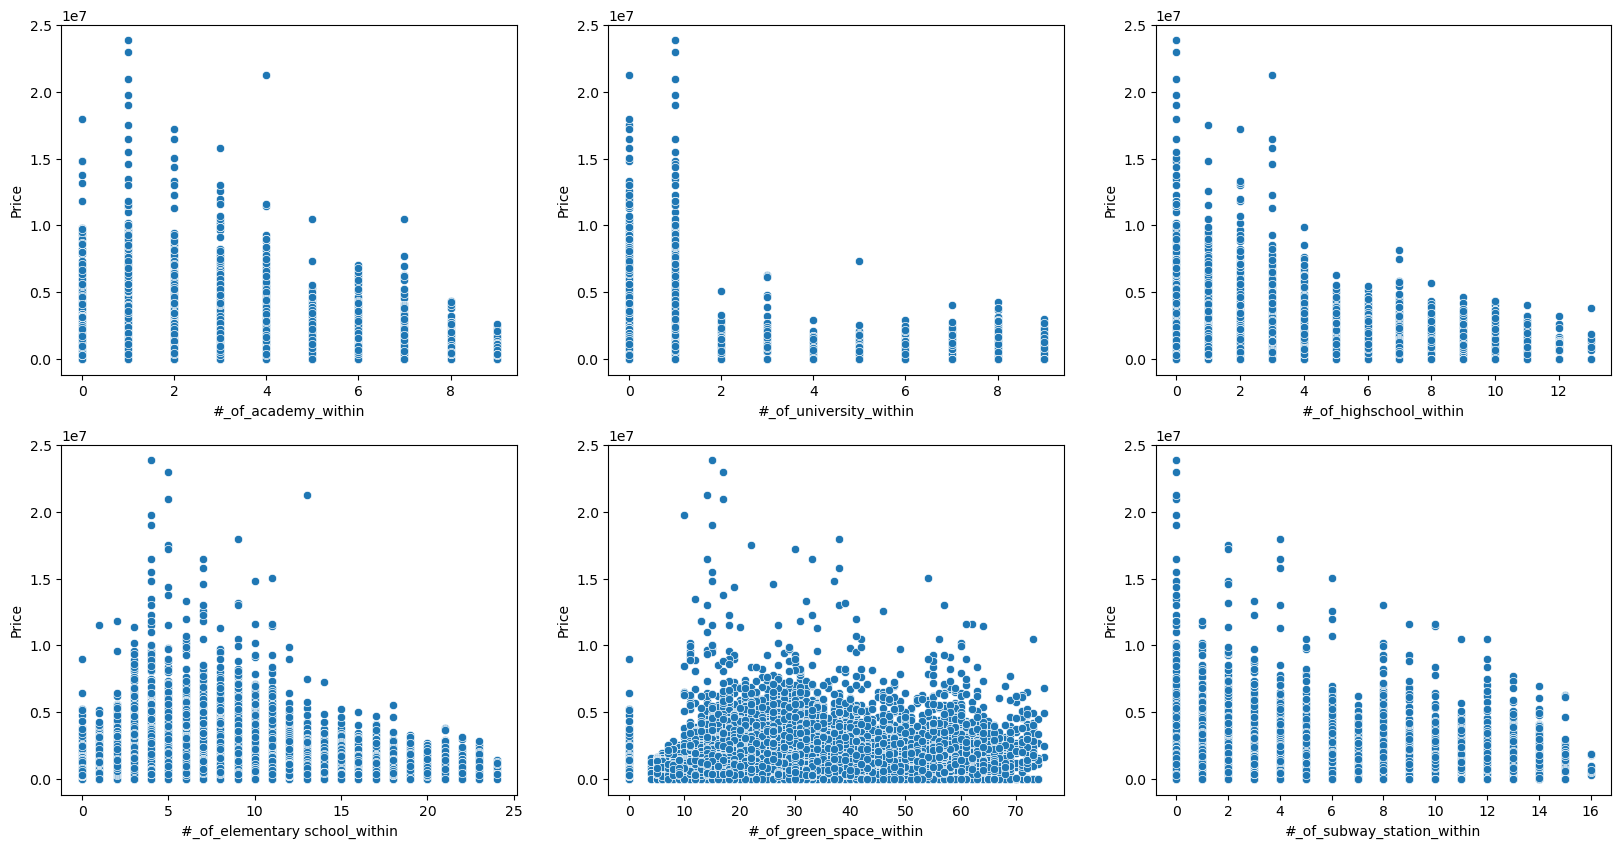

In [76]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(2,3,figsize=(20,10))

sns.scatterplot(data=house_prices_gpd_clean,x='#_of_academy_within',y='Price',ax=ax1)
sns.scatterplot(data=house_prices_gpd_clean,x='#_of_subway_station_within',y='Price',ax=ax6)
sns.scatterplot(data=house_prices_gpd_clean,x='#_of_university_within',y='Price',ax=ax2)
sns.scatterplot(data=house_prices_gpd_clean,x='#_of_highschool_within',y='Price',ax=ax3)
sns.scatterplot(data=house_prices_gpd_clean,x='#_of_elementary school_within',y='Price',ax=ax4)
sns.scatterplot(data=house_prices_gpd_clean,x='#_of_green_space_within',y='Price',ax=ax5)

THE DATA SEEMS TO HAVE A SIGNIFICANT AMOUNT OF NOISE AND TRENDS ARE HARD TO FIND. WE MUST FIRTHER CATEGORIZE THE DATA AS DIFFERENT FACTORS MAY AFFECT DIFFERENT HOMES DIFFERENTLY. 

<Axes: xlabel='within_green_space', ylabel='Price'>

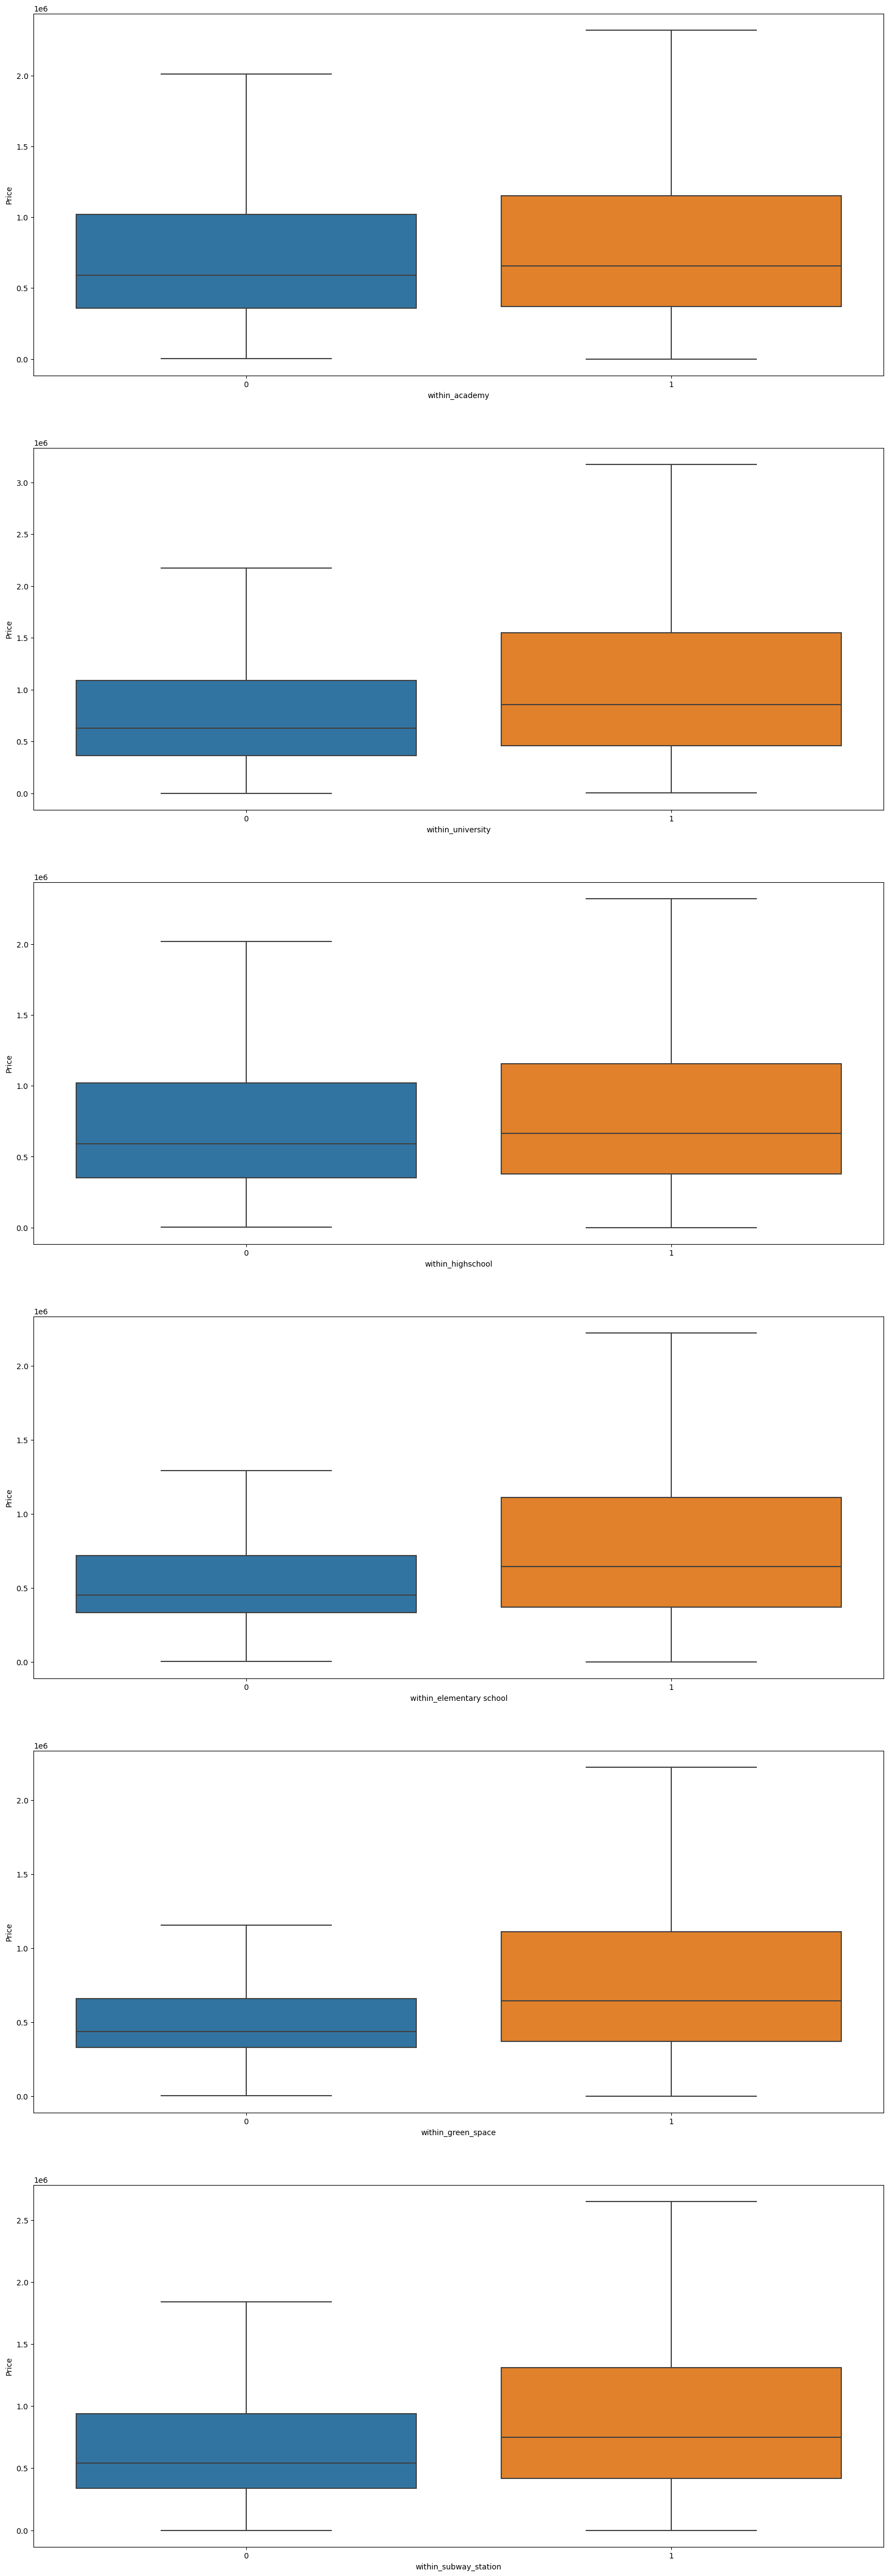

In [77]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(6,1,figsize=(20,60))

sns.boxplot(data=house_prices_gpd_clean,x='within_academy',y='Price',ax=ax1,showfliers=False)
sns.boxplot(data=house_prices_gpd_clean,x='within_subway_station',y='Price',ax=ax6,showfliers=False)
sns.boxplot(data=house_prices_gpd_clean,x='within_university',y='Price',ax=ax2,showfliers=False)
sns.boxplot(data=house_prices_gpd_clean,x='within_highschool',y='Price',ax=ax3,showfliers=False)
sns.boxplot(data=house_prices_gpd_clean,x='within_elementary school',y='Price',ax=ax4,showfliers=False)
sns.boxplot(data=house_prices_gpd_clean,x='within_green_space',y='Price',ax=ax5,showfliers=False)

This trends are somewhat dissapointing. 

i believe the reason for this is that we are combining prices from different years, different locations all togheter. it is possible that homes are split into smaller market segments and each market has its own trends and factors that matter to them... 

example: 

for homes that are super expensive, perhaps they are for custum homes and those custumers look for areas that are less crowded and thats what gives value for them. 

for homes that are within the mean of cost (working class) what gives worth for them is how close they are to transportation, safety etc. 

for families what could give them value is how close they are to schools as it leads to safer locations with speedbumps and its is easier for them to care for their children education... 

thus the message in this is that different people want different things, and the homes near the things they want are dominated by this market population and what they would spend to aquire such homes. 

what i am trying to do now is further categorize the homes by their market group. we can try to do this by: 

1. categorizing by house prices 
2. categorizing geospacially (dowtown,suburbs,family friendly,etc.. )
3. categorize by building type! most important try this first 
